In [ ]:
!pip install datasets

## Download trained model

the following CLI downloads a SavedModel from Vertex Pipeline to the local file system

In [2]:
!mkdir ./tmp
!gsutil cp -r gs://gde-temp ./tmp

mkdir: cannot create directory ‘./tmp’: File exists
Copying gs://gde-temp/model-6364127233195376640/custom-trained/2022-09-09T14:23:57.679818Z/keras_metadata.pb...
Copying gs://gde-temp/model-6364127233195376640/custom-trained/2022-09-09T14:23:57.679818Z/saved_model.pb...
Copying gs://gde-temp/model-6364127233195376640/custom-trained/2022-09-09T14:23:57.679818Z/variables/variables.data-00000-of-00001...
Copying gs://gde-temp/model-6364127233195376640/custom-trained/2022-09-09T14:23:57.679818Z/variables/variables.index...
/ [4 files][ 65.1 MiB/ 65.1 MiB]                                                
Operation completed over 4 objects/65.1 MiB.                                     


## Move downloaded model to `model` directory

In [2]:
model_path = "model"

!mkdir {model_path}
!cp -r tmp/gde-temp/model-6364127233195376640/custom-trained/2022-09-09T14:23:57.679818Z/* model/

mkdir: cannot create directory ‘model’: File exists


## Inspect the signatures of the model

In [3]:
!saved_model_cli show --dir {model_path} --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['image_xf'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 128, 128, 3)
      name: serving_default_image_xf:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 128, 128, 35)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


## Load model

In [4]:
import tensorflow as tf

model = tf.keras.models.load_model(model_path)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_xf (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['image_xf[0][0]']               
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

## Run prediction on a single image

### Load sidewalk dataset

In [ ]:
from datasets import load_dataset

hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)

ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
inference = ds["test"]

### Get a test image

In [32]:
import numpy as np

test_image = inference[0]["pixel_values"]
test_gt = inference[0]["label"]

test_image = test_image.resize((128, 128))
test_gt = test_gt.resize((128, 128))
print(type(test_image))

input_numpy = np.array(test_image)
input_tensor = tf.convert_to_tensor(input_numpy)
input_tensor = input_tensor[tf.newaxis, ...]
print(input_tensor.shape)

<class 'PIL.Image.Image'>
(1, 128, 128, 3)


### Get prediction (Logit)

In [33]:
prediction = model.predict(input_tensor)
print(prediction.shape)

seg_mask = tf.math.argmax(prediction, -1)
seg_mask = tf.squeeze(seg_mask)
print(seg_mask.shape)

(1, 128, 128, 35)
(128, 128)


### Visualize the result

In [34]:
def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
        [190, 190, 0],
        [0, 255, 0],
        [0, 0, 255],
        [170, 0, 255],
        [84, 84, 0],
        [84, 170, 0],
        [84, 255, 0],
        [170, 84, 0],
        [170, 170, 0],
        [170, 255, 0],
        [255, 84, 0],
        [255, 170, 0],
        [255, 255, 0],
        [33, 138, 200],
        [0, 170, 127],
        [0, 255, 127],
        [84, 0, 127],
        [84, 84, 127],
        [84, 170, 127],
        [84, 255, 127],
        [170, 0, 127],
        [170, 84, 127],
        [170, 170, 127],
        [170, 255, 127],
        [255, 0, 127],
        [255, 84, 127],
        [255, 170, 127],
    ]

In [35]:
def get_seg_overlay(image, seg):
    color_seg = np.zeros(
        (seg.shape[0], seg.shape[1], 3), dtype=np.uint8
    )  # height, width, 3
    palette = np.array(sidewalk_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    return img

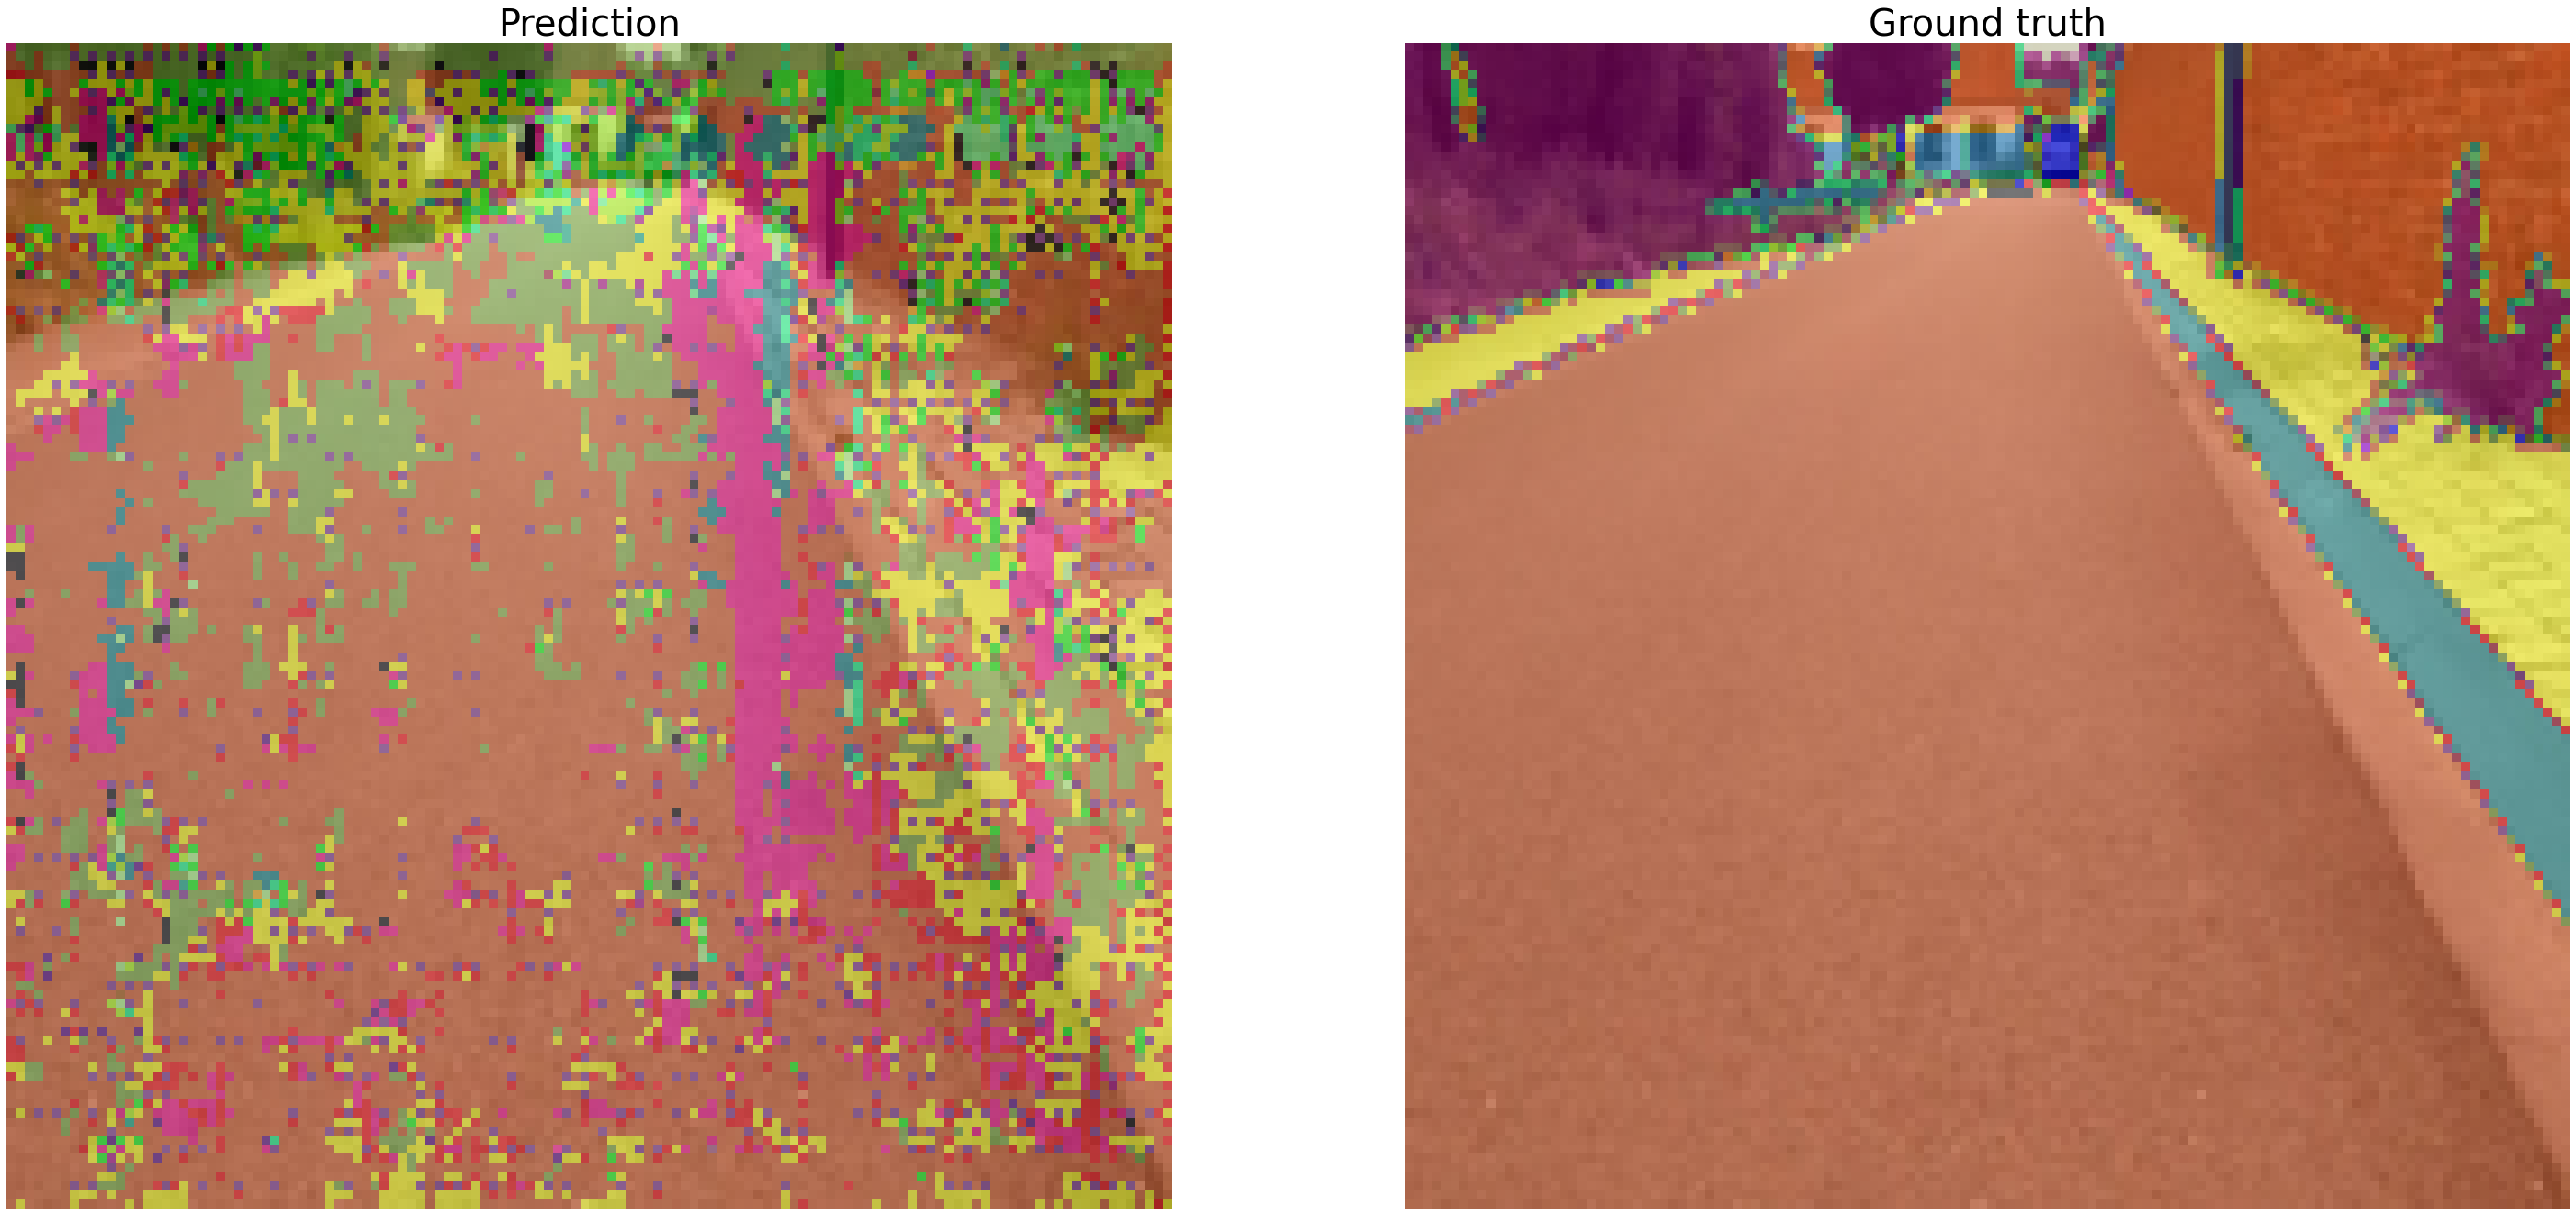

In [36]:
import matplotlib.pyplot as plt

pred_img = get_seg_overlay(test_image, seg_mask.numpy())
gt_img = get_seg_overlay(test_image, np.array(test_gt))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {"fontsize": 40})
axs[0].imshow(pred_img)
axs[0].axis("off")
axs[1].set_title("Ground truth", {"fontsize": 40})
axs[1].imshow(gt_img)
axs[1].axis("off")

plt.show()